In [320]:
cd /orange/adamginsburg/jwst/jw02731/code

/orange/adamginsburg/jwst/jw02731/code


In [321]:
import filter_each_filter, filtering, starfinding
import imp
imp.reload(filter_each_filter)
imp.reload(filtering)
imp.reload(starfinding)
from filter_each_filter import do_all_filtering

In [322]:
import os
os.environ['WEBBPSF_PATH'] = '/orange/adamginsburg/jwst/webbpsf-data/'
with open(os.path.expanduser('~/.mast_api_token'), 'r') as fh:
    os.environ['MAST_API_TOKEN'] = fh.read().strip()
import webbpsf

In [319]:
do_all_filtering('L3/t/jw02731-o001_t017_nircam_clear-f335m_i2d.fits', nsigma_threshold=5)

Set DATE-AVG to '2022-06-03T12:17:28.706' from MJD-AVG.
Set DATE-END to '2022-06-03T14:54:43.830' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.568124 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654350045.384 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Started /orange/adamginsburg/jwst/jw02731//L3/t/jw02731-o001_t017_nircam_clear-f335m_i2d.fits saturated at t=1660337222.4 [filter_each_filter]


Set OBSGEO-B to   -31.568124 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654350045.384 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


ReadTimeout: HTTPSConnectionPool(host='mast.stsci.edu', port=443): Read timed out. (read timeout=None)

In [ ]:
import regions
rois = regions.Regions.read('/orange/adamginsburg/jwst/jw02731/ROIs.reg')
r0, r1 = rois
r2, r3 = regions.Regions.read('/orange/adamginsburg/jwst/jw02731/smaller_roi.reg')

In [ ]:
fh = fits.open(glob.glob(f'jw02731-o001_t017_nircam_*{filtername.lower()}*_i2d.fits')[0])
ww = wcs.WCS(fh[1].header)
mask = (r0 | r1).to_pixel(ww).to_mask()
original_cutout = mask.cutout(fh[1].data)
original_wcs_cutout = ww[mask.bbox.get_overlap_slices(fh[1].data.shape)[0]]
header = fh[0].header
header.update(fh[1].header)
header.update(original_wcs_cutout.to_header())
fits.PrimaryHDU(data=original_cutout, header=header).writeto(f'{filtername}_original_cutout.fits', overwrite=True)

In [ ]:
import warnings
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
from astropy.visualization import simple_norm
from astropy import wcs
from astropy.io import fits
import glob
import numpy as np

def check_image(filtername, catalog=None, colorcol='flux', noface=False, min_percent=0.1, max_percent=99,
                stretch='asinh', cmap='gray_r', rr=r0, alpha=0.85, linewidth=0.25, marker='o',
                images=[
                    '{filtername}_original_cutout.fits',
                    #f'{filtername}_saturated_stars_removed.fits',
                    '{filtername}_filter-based-background-subtraction.fits',
                    '{filtername}_originalimage_stars_removed.fits',
                    #f'{filtername}_psfphot_stars_removed.fits'
                       ]
               ):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')


        pl.figure(figsize=(22,9))
        for ii,imgtype in enumerate(images):
            imgtype = imgtype.format(filtername=filtername)
            print(imgtype)
            fn = glob.glob(imgtype)[0]
            data = fits.getdata(fn)

            header = fits.getheader(fn)
            ww = wcs.WCS(header)
            mask = rr.to_pixel(ww).to_mask()
            #except Exception as ex:
            #    print(ex)
            #    header = fits.getheader(fn, ext=1)
            #    ww = wcs.WCS(header)
            #    mask = rr.to_pixel(ww).to_mask()
            
            mdata = mask.cutout(data)
            #print(f"mdata shape={mdata.shape}")
            bigslc, smlslc = mask.bbox.get_overlap_slices(data.shape)
            assert bigslc is not None
            ax = pl.subplot(1,3, ii+1, projection=ww[bigslc])
            ax.imshow(mdata, norm=simple_norm(mdata, min_percent=min_percent, max_percent=max_percent, stretch=stretch), cmap=cmap)
            axlims = ax.axis()
            #print(axlims)
            if catalog:
                if 'x_fit' in catalog.colnames:
                    xx = catalog['x_fit'] - bigslc[1].start
                    yy = catalog['y_fit'] - bigslc[0].start
                elif 'xcentroid' in catalog.colnames:
                    xx = catalog['xcentroid'] - bigslc[1].start
                    yy = catalog['ycentroid'] - bigslc[0].start
                elif 'x_peak' in catalog.colnames:
                    xx = catalog['x_peak'] - bigslc[1].start
                    yy = catalog['y_peak'] - bigslc[0].start
                else:
                    raise ValueError(str(catalog.colnames))
                cc = catalog[f'{colorcol}_fit'] if f'{colorcol}_fit' in catalog.colnames else catalog[f'{colorcol}']
                print(xx.mean(), yy.mean(), bigslc)
                if 'roundness1' in catalog.colnames:
                    unround = (np.abs(catalog['roundness1']) > 0.25) | np.abs(catalog['roundness2'] > 0.25)
                else:
                    unround = np.zeros(len(catalog), dtype='bool')
                if noface:
                    ax.scatter(xx[~unround], yy[~unround], marker=marker, facecolor='none', edgecolor='blue', alpha=alpha, linewidth=linewidth)
                    ax.scatter(xx[unround], yy[unround], marker=marker, facecolor='none', edgecolor='red', alpha=alpha, linewidth=linewidth)
                    print(f"Made scatterplot for plot {ii}")
                else:
                    scat = ax.scatter(xx, yy, marker=marker, c=cc, cmap='jet', alpha=alpha, linewidth=linewidth, norm=simple_norm(cc, max_percent=99., min_percent=1.))
                    pl.draw()
                    scat.set_edgecolors(scat.get_facecolors())
                    scat.set_facecolor('none')
                ax.axis(axlims)

In [ ]:
from astropy.table import Table
def plot_with_catalog(filtername, **kwargs):
    catalog = Table.read(f'{filtername}_fullfield_ePSF_photometry.fits')
    #print(catalog)
    check_image(filtername, catalog, **kwargs)

In [ ]:
cd /orange/adamginsburg/jwst/jw02731/background_estimation_cutout/

In [ ]:
plot_with_catalog('F335M', noface=True, stretch='log', min_percent=5)

In [ ]:
plot_with_catalog('F335M', noface=True, stretch='log', min_percent=5, rr=r2, linewidth=1, marker='s')

In [ ]:
plot_with_catalog('F335M', noface=True, rr=r1)

In [ ]:
filtername = 'F335M'
catalog = Table.read(f'{filtername}_fullfield_ePSF_photometry.fits')

In [ ]:
pl.scatter(catalog['roundness1'], catalog['roundness2'], c=catalog['sharpness'], alpha=0.5)

In [141]:
from photutils.detection import IRAFStarFinder, DAOStarFinder, find_peaks

In [144]:
from astropy.stats import mad_std

In [156]:
data = fits.getdata(f'{filtername}_filter-based-background-subtraction.fits')
findpeakscat = find_peaks(data, 3*mad_std(data))
findpeakscat.colnames

['x_peak', 'y_peak', 'peak_value']

F335M_original_cutout.fits
72.34266342141864 -351.98313630041724 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 0
F335M_filter-based-background-subtraction.fits
72.34266342141864 -351.98313630041724 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 1
F335M_originalimage_stars_removed.fits
72.34266342141864 -351.98313630041724 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 2


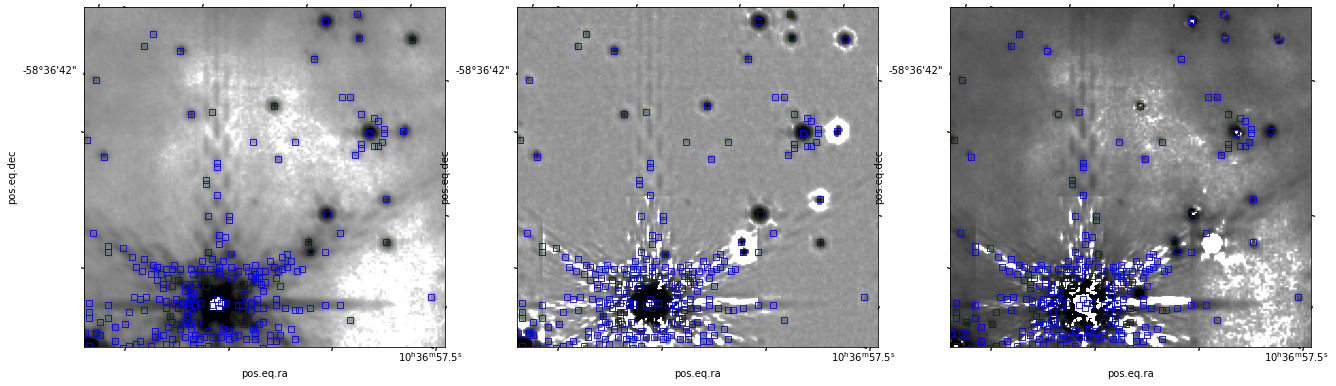

In [157]:
check_image(filtername, catalog=findpeakscat, noface=True, stretch='log', min_percent=5, rr=r2, linewidth=1, marker='s', colorcol='peak_value')

In [163]:
from filtering import get_fwhm

In [179]:
fwhm, fwhm_pix = get_fwhm(fh[0].header)
irafcat = IRAFStarFinder(threshold=3*mad_std(data), fwhm=fwhm_pix)(data)

Set OBSGEO-B to   -31.568124 from OBSGEO-[XYZ].
Set OBSGEO-H to 1654350045.384 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


F335M_original_cutout.fits
84.31156680390887 -309.20949720678067 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 0
F335M_filter-based-background-subtraction.fits
84.31156680390887 -309.20949720678067 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 1
F335M_originalimage_stars_removed.fits
84.31156680390887 -309.20949720678067 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 2


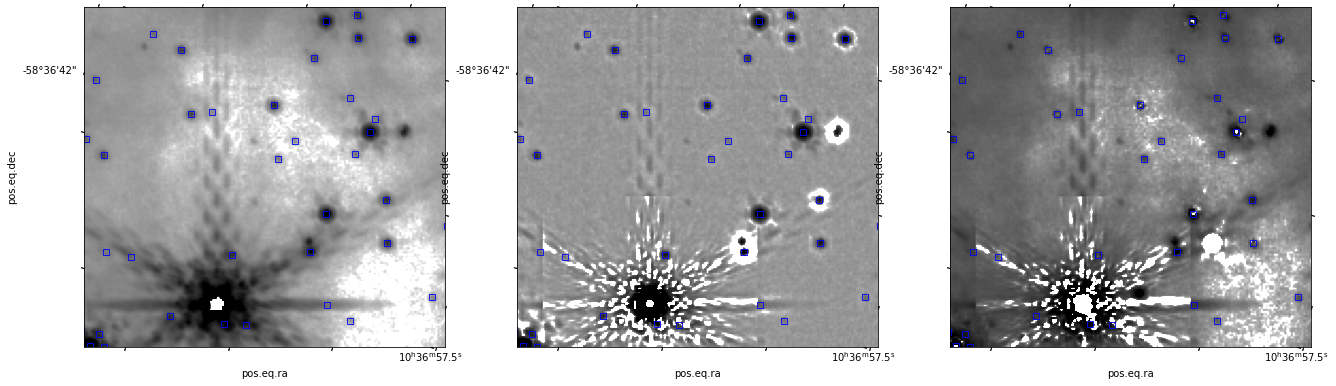

In [180]:
check_image(filtername, catalog=irafcat, noface=True, stretch='log', min_percent=5, rr=r2, linewidth=1, marker='s', )

In [187]:
daocat = DAOStarFinder(threshold=3*mad_std(data), fwhm=fwhm_pix)(data)

F335M_original_cutout.fits
72.88899010965794 -359.3192116880208 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 0
F335M_filter-based-background-subtraction.fits
72.88899010965794 -359.3192116880208 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 1
F335M_originalimage_stars_removed.fits
72.88899010965794 -359.3192116880208 (slice(704, 864, None), slice(202, 372, None))
Made scatterplot for plot 2


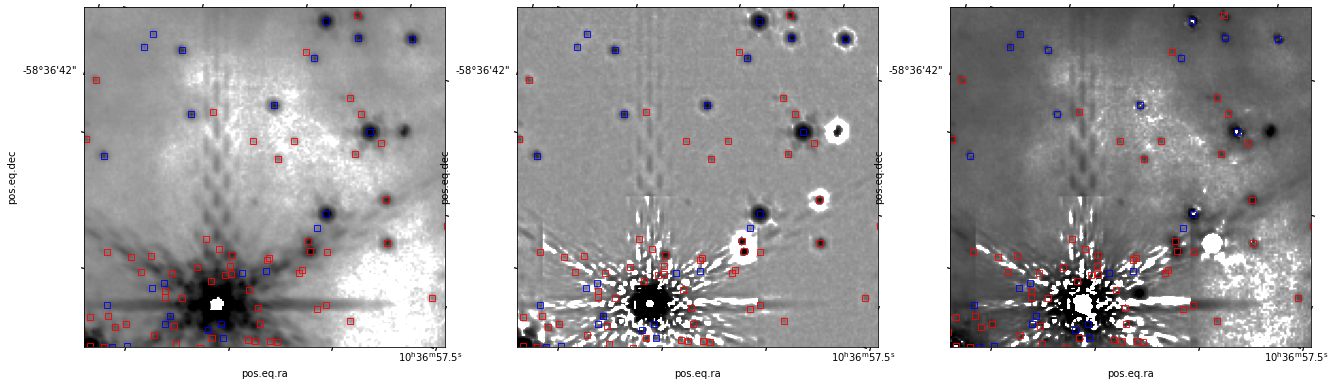

In [188]:
check_image(filtername, catalog=daocat, noface=True, stretch='log', min_percent=5, rr=r2, linewidth=1, marker='s', )

F335M_original_cutout.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 0
F335M_filter-based-background-subtraction.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 1
F335M_originalimage_stars_removed.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 2


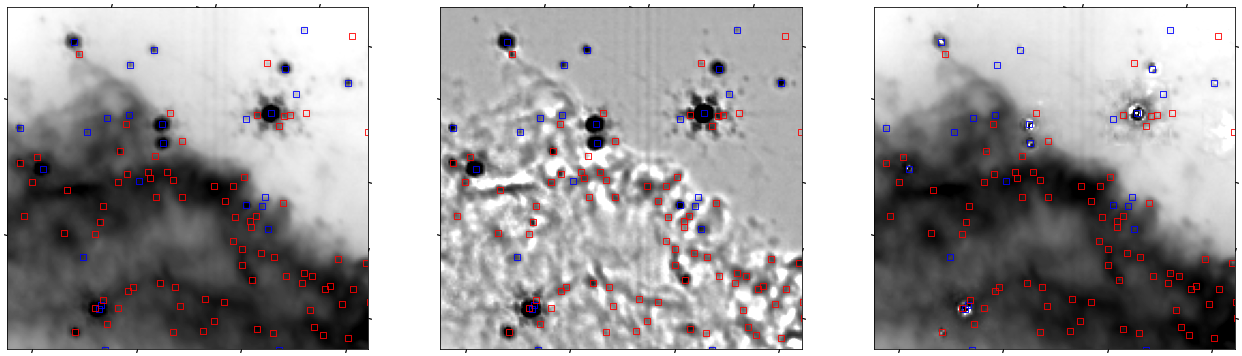

In [195]:
plot_with_catalog('F335M', noface=True, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=1, marker='s')

F335M_original_cutout.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 0
F335M_filter-based-background-subtraction.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 1
F335M_originalimage_stars_removed.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))
Made scatterplot for plot 2


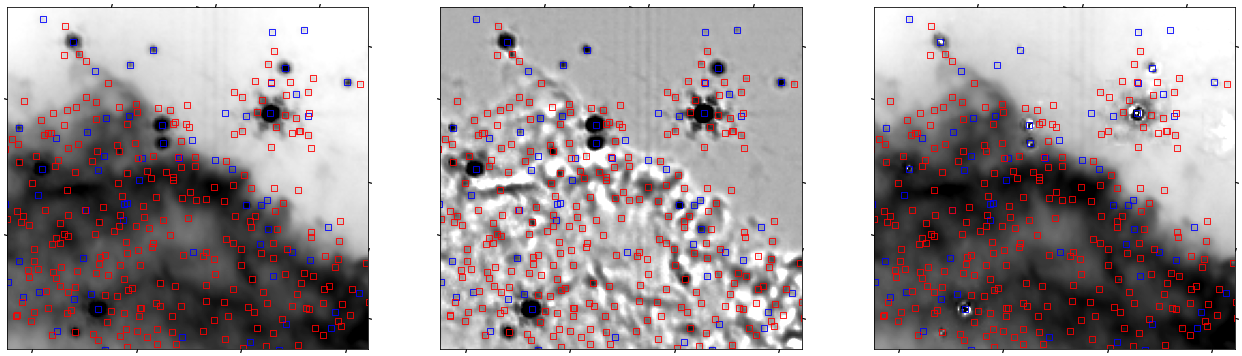

In [197]:
check_image(filtername='F335M', catalog=daocat, noface=True, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=1, marker='s')

F335M_original_cutout.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))
F335M_filter-based-background-subtraction.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))
F335M_originalimage_stars_removed.fits
91.88899010965794 -29.319211688020793 (slice(374, 534, None), slice(183, 352, None))


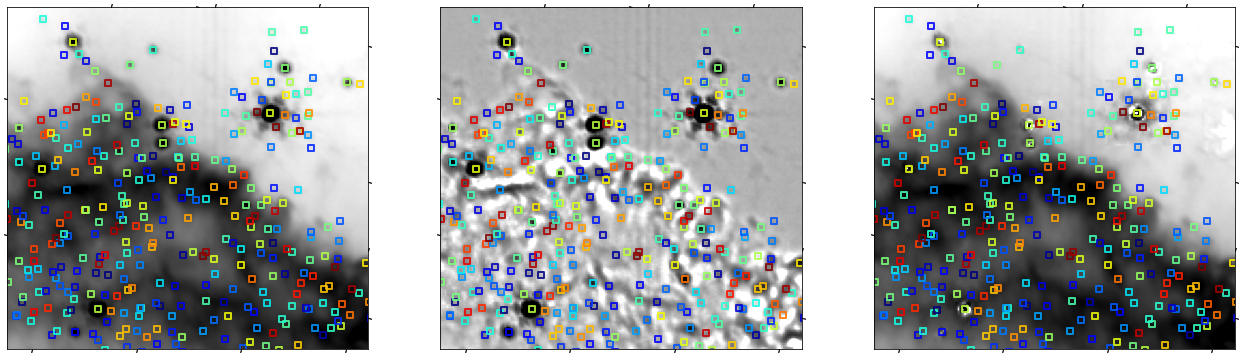

In [250]:
check_image(filtername='F335M', catalog=daocat, noface=False, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=2, marker='s', colorcol='roundness1')

F335M_original_cutout.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))
F335M_filter-based-background-subtraction.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))
F335M_originalimage_stars_removed.fits
111.22394778797272 13.117962042803345 (slice(374, 534, None), slice(183, 352, None))


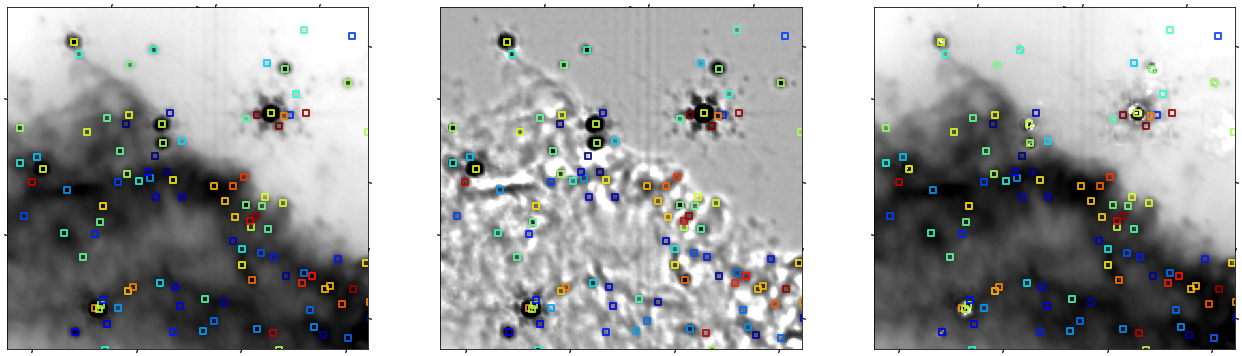

In [251]:
plot_with_catalog('F335M', noface=False, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=2, marker='s', colorcol='roundness1')

F335M_original_cutout.fits
F335M_filter-based-background-subtraction.fits
F335M_psfphot_stars_removed.fits


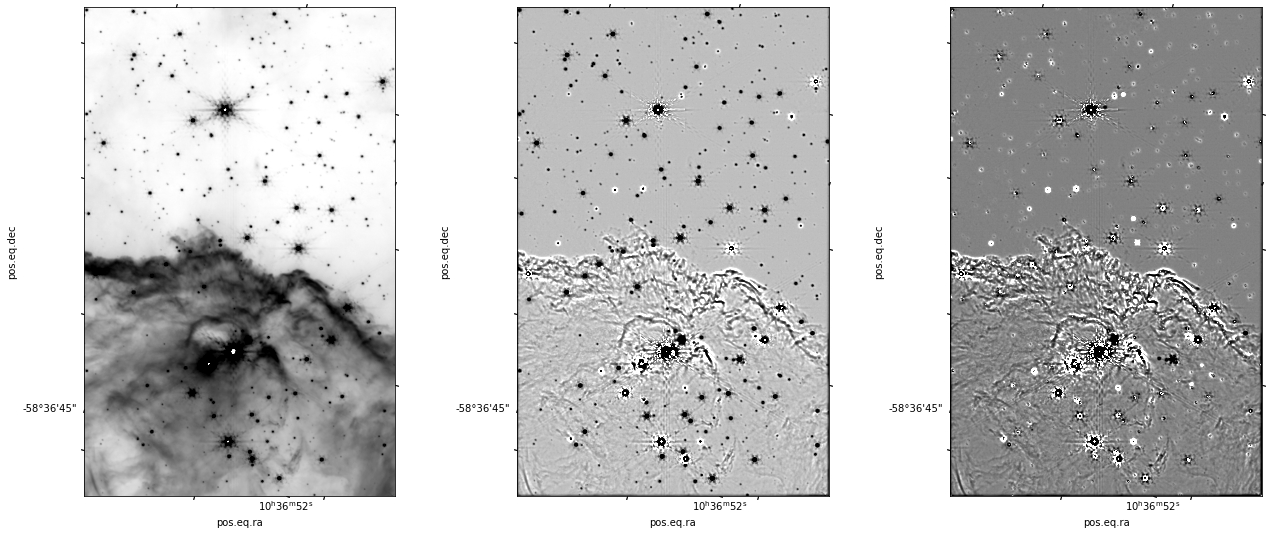

In [257]:
check_image('F335M', catalog=None, noface=False, stretch='asinh', min_percent=3, max_percent=99., rr=(r0|r1), linewidth=2, marker='s', colorcol='roundness1',
            images=[
                    '{filtername}_original_cutout.fits',
                    #f'{filtername}_saturated_stars_removed.fits',
                    '{filtername}_filter-based-background-subtraction.fits',
                    #'{filtername}_originalimage_stars_removed.fits',
                    '{filtername}_psfphot_stars_removed.fits'
                       ])

In [258]:
from scipy import ndimage

In [270]:
sz=51
yy,xx = np.indices([sz,sz])
rr = ((xx-xx.max()/2)**2 + (yy-yy.max()/2)**2)**0.5
noisemap = ndimage.generic_filter(fits.getdata('F335M_psfphot_stars_removed.fits'), mad_std, footprint=rr<sz/2)

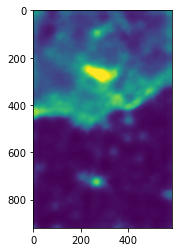

In [271]:
pl.imshow(noisemap, norm=simple_norm(noisemap, max_percent=99.5, stretch='asinh'))

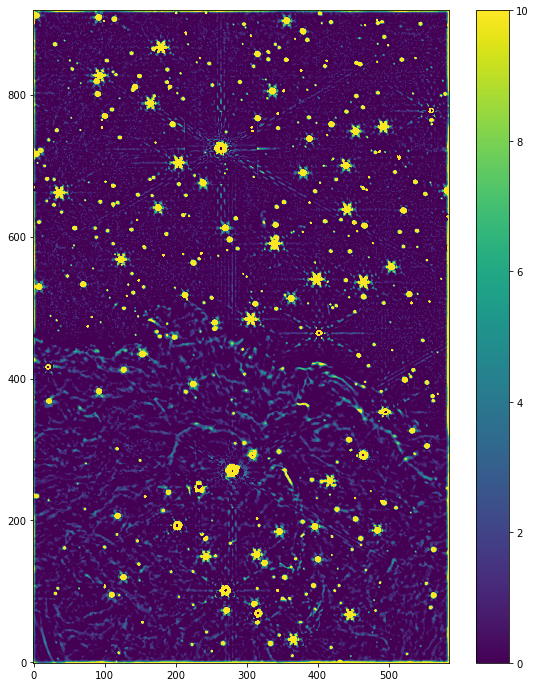

In [272]:
pl.figure(figsize=(10,12))
pl.imshow(fits.getdata(f'{filtername}_filter-based-background-subtraction.fits') / noisemap, origin='lower', vmin=0, vmax=10)
pl.colorbar()

In [273]:
snmap = fits.getdata(f'{filtername}_filter-based-background-subtraction.fits') / noisemap

In [284]:
from photutils.segmentation import detect_sources, SourceCatalog
segment_map = detect_sources(snmap, 5, npixels=10)
segment_sources = SourceCatalog(snmap, segment_map)

In [287]:
seg_tbl = segment_sources.to_table()

In [289]:
seg_tbl['eccentricity']

<Quantity [0.71803155, 0.23786481, 0.99738315, 0.36383448, 0.56333516,
           0.44281123, 0.36061698, 0.25428243, 0.33349039, 0.37070168,
           0.35862831, 0.22939883, 0.46262941, 0.94559827, 0.36034234,
           0.41667425, 0.79479792, 0.52399018, 0.38928646, 0.82626044,
           0.96008879, 0.27386199, 0.93627176, 0.2808431 , 0.92636322,
           0.94041717, 0.31347226, 0.36571999, 0.91055215, 0.58381192,
           0.54050957, 0.48825554, 0.93644595, 0.78915144, 0.77967414,
           0.323672  , 0.67167667, 0.11537235, 0.73239122, 0.34120783,
           0.68071632, 0.36911069, 0.44014881, 0.98156696, 0.55879578,
           0.33445366, 0.46166195, 0.61482523, 0.85003403, 0.39122581,
           0.27646143, 0.30813183, 0.43502677, 0.92752166, 0.44502994,
           0.70687145, 0.90878871, 0.90391549, 0.41241112, 0.95020365,
           0.18435598, 0.43249157, 0.78062394, 0.96574737, 0.96529689,
           0.93778525, 0.39377591, 0.98227828, 0.94109907, 0.3812363 ,
      

(array([ 13.,  23.,  68.,  86.,  45.,  53.,  31.,  43.,  48., 108.]),
 array([0.11537235, 0.20360523, 0.2918381 , 0.38007097, 0.46830385,
        0.55653672, 0.6447696 , 0.73300247, 0.82123535, 0.90946822,
        0.99770109]),
 <BarContainer object of 10 artists>)

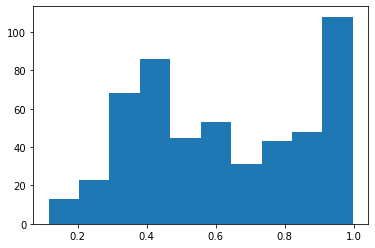

In [290]:
pl.hist(np.array(seg_tbl['eccentricity']))

In [305]:
elongated_map = np.zeros_like(segment_map, dtype='bool')
for row in seg_tbl:
    if row['eccentricity'] > 0.9:
        elongated_map[segment_map.data == (row['label'])] = True

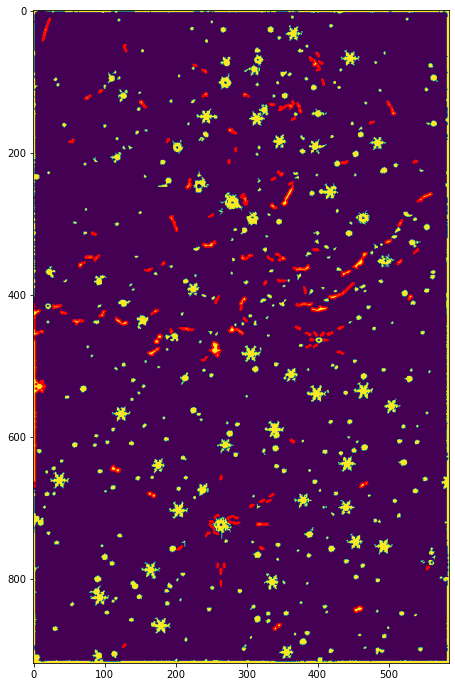

In [306]:
#segment_map[segment_map==0] = np.nan
pl.figure(figsize=(8,12))
pl.imshow(segment_map.data > 0)
pl.contour(elongated_map, colors=['r'], levels=[0.5])

In [307]:
daocatsnm = DAOStarFinder(threshold=3, fwhm=fwhm_pix)(snmap)
daocatsnm_mask = DAOStarFinder(threshold=3, fwhm=fwhm_pix)(snmap, mask=elongated_map)

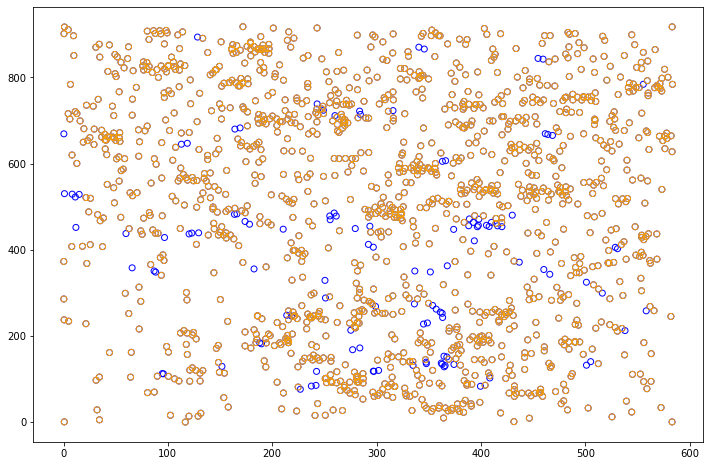

In [312]:
pl.figure(figsize=(12,8))
pl.scatter(daocatsnm['xcentroid'], daocatsnm['ycentroid'], edgecolor='b', facecolor='none')
pl.scatter(daocatsnm_mask['xcentroid'], daocatsnm_mask['ycentroid'], edgecolor='orange', facecolor='none')

F335M_original_cutout.fits
124.29653581692033 116.11363739398935 (slice(374, 534, None), slice(183, 352, None))
F335M_filter-based-background-subtraction.fits
124.29653581692033 116.11363739398935 (slice(374, 534, None), slice(183, 352, None))
F335M_psfphot_stars_removed.fits
124.29653581692033 116.11363739398935 (slice(374, 534, None), slice(183, 352, None))


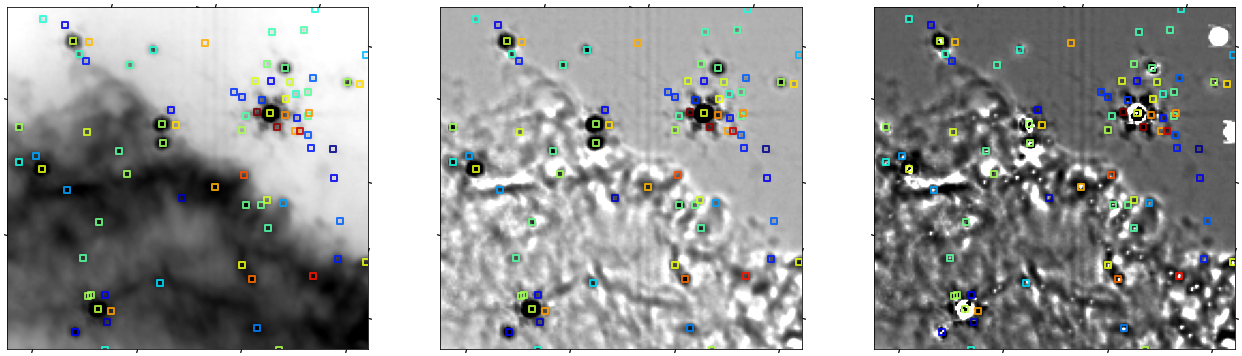

In [313]:
check_image('F335M', catalog=daocatsnm, noface=False, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=2, marker='s', colorcol='roundness1',
            images=[
                    '{filtername}_original_cutout.fits',
                    #f'{filtername}_saturated_stars_removed.fits',
                    '{filtername}_filter-based-background-subtraction.fits',
                    #'{filtername}_originalimage_stars_removed.fits',
                    '{filtername}_psfphot_stars_removed.fits'
                       ])

F335M_original_cutout.fits
125.15616112431154 124.54934647902752 (slice(374, 534, None), slice(183, 352, None))
F335M_filter-based-background-subtraction.fits
125.15616112431154 124.54934647902752 (slice(374, 534, None), slice(183, 352, None))
F335M_psfphot_stars_removed.fits
125.15616112431154 124.54934647902752 (slice(374, 534, None), slice(183, 352, None))


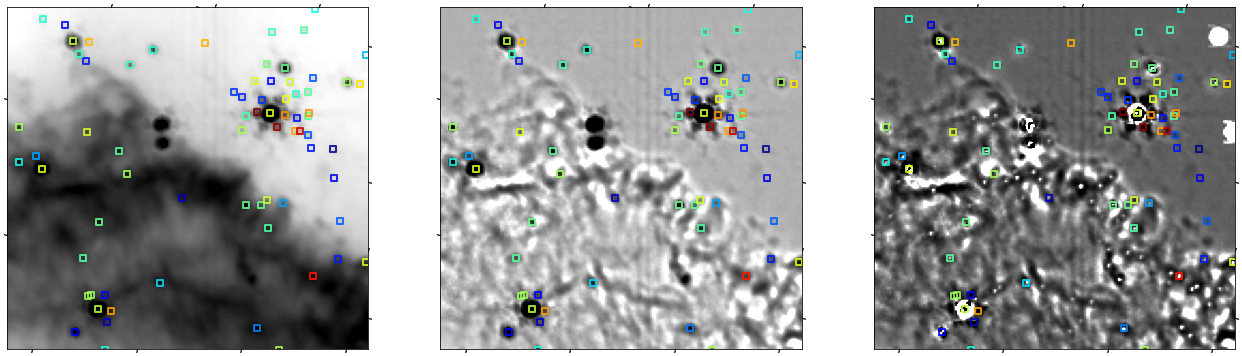

In [315]:
check_image('F335M', catalog=daocatsnm_mask, noface=False, stretch='asinh', min_percent=3, max_percent=99., rr=r3, linewidth=2, marker='s', colorcol='roundness1',
            images=[
                    '{filtername}_original_cutout.fits',
                    #f'{filtername}_saturated_stars_removed.fits',
                    '{filtername}_filter-based-background-subtraction.fits',
                    #'{filtername}_originalimage_stars_removed.fits',
                    '{filtername}_psfphot_stars_removed.fits'
                       ])